# Investigating ESG Performance of the S&P 500: Final Report
### Kevin Vick - CSPB 3022, Fall 2021

## 1. Project Topic 
Environmental, Social, Governance (ESG) represents a common bundle of categories used to screen companies for investment. Companies with superior ESG commitments may be actively selected to form a portfolio, while those with poor ratings may be proactively excluded from an indexed investment. Some intuit that investors who pursue ESG do so at the expense of return even as recent evidence has started to show that ESG investments outperform. I want to explore this by industry, using specific ESG factors to consider recent performance.

As an index, the S&P 500 is designed to track a subset of the exchange-traded equity universe over time. Of note, it has a profitability requirement and is weighted by market capitalization such that it proxies only the performance of large, public companies. I chose to use it as my core framework because it has clearly delineated sectors that convey a relative sense of activity, reducing the need for idiosyncratic knowledge about the business operations of any single company. The index also consists of reasonable number of items, neither too small to be trivial nor too large to challenge standard computational resources.

Given the dominance of continuous data available in the space, this project lends itself well to the regression option.

### 2. Data

While a little more complicated, my approach involves the creation of a new database with the potential for more novel analysis. I was fortunate to find a dataset published by [Ziqi Chen on Kaggle](https://www.kaggle.com/zc1111/sp-500-daily-data-till-20210130) with daily price information on every equity that was in the S&P 500. Data began on the date the stock was first added and continued through January 29, 2021. A significant bright line with the index is that it is not static. Companies are added to and removed from the S&P 500 on a near-monthly basis to reflect corporate actions such that there is a wide variety of index inception dates. To compare a fixed basket of companies over time, it is necessary to exclude those that were not part of the index throughout the entire period of interest.

To get ESG metrics and industry classifiers, I had to combine my price data with ratings information published by FTSE Russell accessed via the university’s [Mergent Online subscription](https://www-mergentonline-com.colorado.idm.oclc.org/compsearch.asp), extacting subsets of stock information in groups of 10. In integrating a fixed ratings stock with the flow of price, it is necessary to reduce price to a single return over a specified period. This implicitly assumes the most recent rating reflects all retroactive information in the chosen period. 

### 3. Data Cleaning and EDA

Working backwards from 2021, I manually removed companies in reverse order of their index tenure as maintained by [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) and considered a five-year period going back to Jan 29, 2016 sufficient to investigate a business cycle. 

Reducing a temporal series to a cross-sectional summary to match the rest of the data is particularly influenced by the choice of period, so I sought dates that would avoid cutoffs of significance. Monthly data was selected as of the final trading day of the month, avoiding the noise of daily returns and sparsity of annual returns. 103 stocks were ultimately eliminated, leaving 396 items for for potential study (companies can list multiple share classes and the number of stocks in the index only approximates 500).

Using each stock’s ticker as the merge key because it was unique across both sources, a company’s name, sector and subsidiary industry were collected, as well as overall ESG ratings that had both a sub-score and exposure rating for each of the Environmental, Social, and Governance pillars. FTSE Russell uses a scale from 0-5 for all quantitative values, with 0 representing the minimum (worse when normative) and 5 representing the maximum (best when normative). No missing values were identified for any attribute from either source.

The data as merged has 72 columns (11 with distinct schema and 61 prices by date, ignoring the index), each with 396 rows. This is quickly reduced to 70 by dropping two columns with relative rankings that no longer apply to the manually-cleaned set, leaving the abstraction as follows:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy.stats as stats
import sklearn.model_selection as ms
import statsmodels.formula.api as smf
import statsmodels.api as sm

esg = pd.read_csv('ESG Data.csv').iloc[:,0:10].dropna() # empty csv columns but not missing data
esg =  esg.drop(['ESG Rating', 'Relative Percentile Rank'], axis=1) # drop less granular features
industry = pd.read_csv('Industry Data.csv')
prices = pd.read_csv('Stock Price.csv')
main = pd.merge(left = esg, right=industry, left_on='Ticker', right_on = 'Ticker')
main = pd.merge(left = main, right=prices, left_on='Ticker', right_on = 'Ticker').set_index('Ticker')
main

,Company Name,Environmental Score,Environmental Exposure,Social Score,Social Exposure,Governance Score,Governance Exposure,Sector,Industry,1/29/2016,...,4/30/2020,5/29/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/30/2020,11/30/2020,12/31/2020,1/29/2021
Ticker,,,,,,,,,,,,,,,,,,,,,
A,Agilent Technologies,3.7,2.5,3.5,2.8,3.1,2.3,Health Care,Health Care Equipment,35.97,...,76.24,87.65,88.07,96.00,100.08,100.59,101.92,116.71,118.30,120.17
AAL,American Airlines Group,3.5,3.0,4.3,2.0,3.1,2.3,Industrials,Airlines,37.26,...,12.01,10.50,13.07,11.12,13.05,12.29,11.28,14.13,15.77,17.17
AAP,Advance Auto Parts,0.5,2.0,2.2,2.0,5.0,2.0,Consumer Discretionary,Automotive Retail,149.86,...,120.32,138.65,142.00,149.66,155.82,153.26,147.05,147.47,157.51,149.14
AAPL,Apple Inc.,3.9,2.7,3.4,2.7,3.9,2.3,Information Technology,"Technology Hardware, Storage & Peripherals",22.55,...,72.99,79.21,90.88,105.89,128.82,115.61,108.67,119.05,132.69,131.96
ABBV,AbbVie Inc,3.2,2.5,3.3,1.5,3.3,2.3,Health Care,Pharmaceuticals,43.97,...,79.19,89.28,94.59,92.55,93.39,85.41,84.12,103.37,105.91,102.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,Xylem Inc.,4.3,2.3,3.0,2.3,4.0,2.3,Industrials,Industrial Machinery,33.71,...,71.18,65.94,64.57,72.54,79.95,83.88,86.89,95.97,101.79,96.59
YUM,Yum Brands,4.6,2.5,3.8,2.8,3.0,2.0,Consumer Discretionary,Restaurants,47.70,...,85.18,88.89,86.10,90.20,95.42,90.89,92.91,105.80,108.56,101.49
ZBH,Zimmer Biomet Holdings,2.0,2.0,2.0,2.5,3.0,2.0,Health Care,Health Care Equipment,95.33,...,119.05,125.65,118.96,134.41,140.41,135.92,131.89,148.88,154.09,153.67


84.7% of the data is comprised only of prices. To reduce the burden of carrying this forward while recognizing most of it will ultimately get aggregated away, we can parse the five-year return for each stock at this stage. Calculating a simple holding period return is sufficient; so we parse the data into non-price and price data, transform the price data to a return, then recombine the two subsets with another merge operation.

In [2]:
left_vals = main.iloc[:, :9]
right_vals = (((main['1/29/2021']/main['1/29/2016'])-1)*100).to_frame(name ='Total Return')
final_data = pd.merge(left = left_vals, right = right_vals, left_on='Ticker', right_on = 'Ticker')
final_data

,Company Name,Environmental Score,Environmental Exposure,Social Score,Social Exposure,Governance Score,Governance Exposure,Sector,Industry,Total Return
Ticker,,,,,,,,,,
A,Agilent Technologies,3.7,2.5,3.5,2.8,3.1,2.3,Health Care,Health Care Equipment,234.083959
AAL,American Airlines Group,3.5,3.0,4.3,2.0,3.1,2.3,Industrials,Airlines,-53.918411
AAP,Advance Auto Parts,0.5,2.0,2.2,2.0,5.0,2.0,Consumer Discretionary,Automotive Retail,-0.480448
AAPL,Apple Inc.,3.9,2.7,3.4,2.7,3.9,2.3,Information Technology,"Technology Hardware, Storage & Peripherals",485.188470
ABBV,AbbVie Inc,3.2,2.5,3.3,1.5,3.3,2.3,Health Care,Pharmaceuticals,133.068001
...,...,...,...,...,...,...,...,...,...,...
XYL,Xylem Inc.,4.3,2.3,3.0,2.3,4.0,2.3,Industrials,Industrial Machinery,186.532186
YUM,Yum Brands,4.6,2.5,3.8,2.8,3.0,2.0,Consumer Discretionary,Restaurants,112.767296
ZBH,Zimmer Biomet Holdings,2.0,2.0,2.0,2.5,3.0,2.0,Health Care,Health Care Equipment,61.197944


This produces a final abstraction:

| Feature Name |Description | Datatype |
| ----------- | ----------- | :-----------: |
|Ticker | index with abbreviated semantic meaning | string |
|Company Name | full name of ticker | string |
|Environmental Score | combined rating for biodiversity, climate change, pollution & resources, water security | float |
|Environmental Exposure | specific vulnerability to environmental score factors | float |
|Social Score | combined rating for labor standards, human rights & community, health & safety, customer responsibility | float |
|Social Exposure | specific vulnerability to social score factors | float |
|Governance Score | combined rating for tax transparency, risk management, corporate governance, anti-corruption | float |
|Governance Exposure | specific vulnerability to governance score factors | float |
|Sector | highest level taxonomy according to The Global Industry Classification Standards (GICS®) | string |
|Industry | secondary, more specific GICS taxonomy based on sector  | string |
|5-Year Return, 1/16-1/21| calculated five-year holding period return, 1/29/2016 - 1/29/2021| float|

An investigation on the frequency of score and exposure for each ESG category seems valuable for EDA as there are clear buckets and unknown distribution(s). 

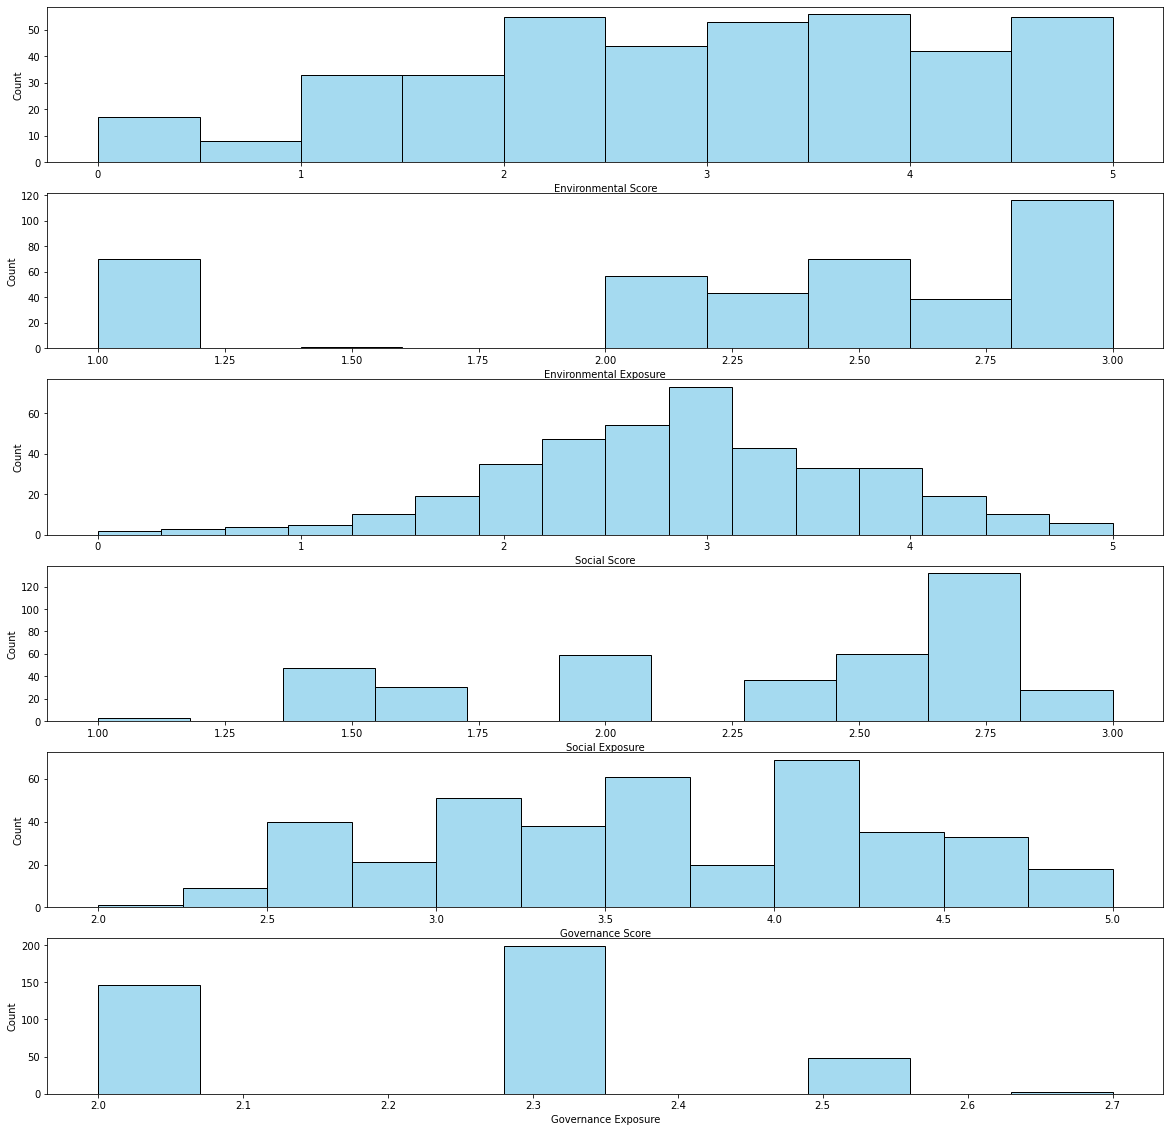

In [3]:
f, axes = plt.subplots(6, figsize=(20, 20))
for ax, feature in zip(axes.flat, final_data.columns[1:7]):
    sb.histplot(final_data[feature] , color="skyblue", ax=ax)

The results are revealing for their contrast. Select conclusions were developed about score and exposure:

### Score
- Environmental: roughly uniformly distributed, especially between 1 and 5
- Social: approximates normal distribution most closely
- Governance: quad-modal about 2.5, 3.0, 3.5, 4.0

### Exposure
- Environmental: ~15% of equities rated 1.0, rest exlusively between 2.0-3.0
- Social: trimodal about 1.5, 2.0, 2.75
- Governance: domindated by buckets of 2.0, 2.3, 2.5

Taken together, scores do not seem to be developed using the same criteria across ESG categories. Environmental scores may employ a relative standard by comparing against other companies given the approximate uniform distribution, while social scores may employ an absolute one in light of the approximate normal distribution. Governance scores may be reliant on too-few subcriteria given the groupings of common rating frequencies.

Exposures are likewise disparate. Environmental is more binary in that all scores are either 1 or between 2 and 3, with the amount of concentration implying possible greenwashing by understating the spectrum of potential exposure. Social exposure, like governance scores, may be fitting to an abstract category. The homogeneity of governance exposure, however, might be most alarming; all scores are between 2 and 2.7, indicating little, if any, information discrimination.

With these issues noted, I also conducted a correlation analysis in preparation for regression to investigate how the quantitative attributes move together, independent of their scenario-realness.

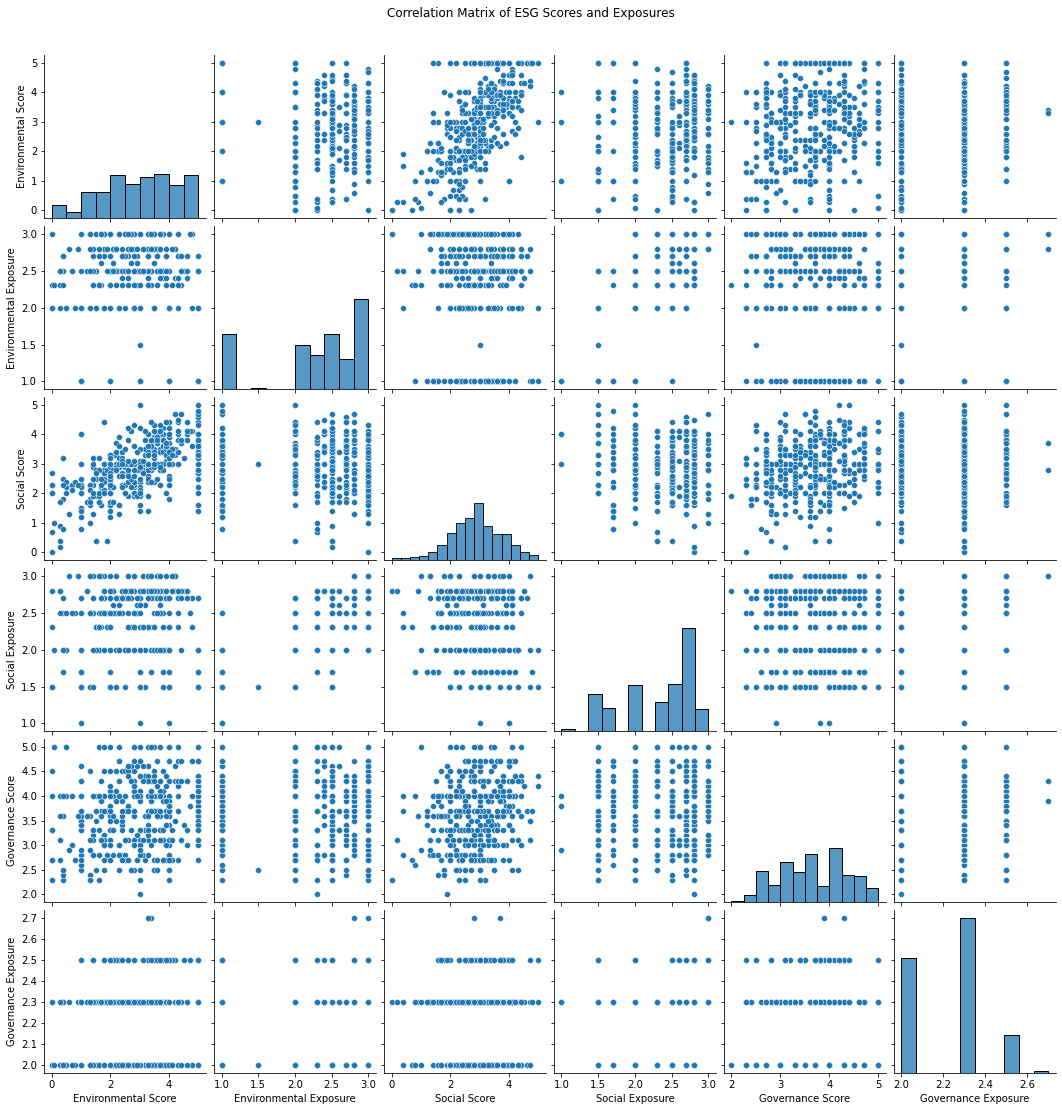

In [4]:
temp = sb.pairplot(final_data.iloc[:, 1:7])
temp.fig.suptitle('Correlation Matrix of ESG Scores and Exposures', y = 1.03)
plt.show()

Useful at a glance, scores are somewhat positively correlated with each other, especially those for environmental and social categories. The lack of stratification for exposure shows little in the way of information. Across categories, intraclass comparisons between score and exposure appear to have slight negative correlation, but there is likewise little information for interclass relationships across score and exposure.

Given the difficulty of absorbing the impact of repeated string data, categorical features were also visualized as part of EDA. The following pie chart shows that all sectors have signifcant representation, with the most common only 2.8 times as frequent as the least common. 

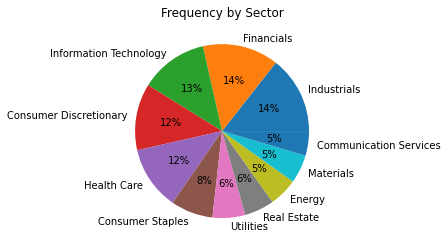

In [5]:
sector_freq = main['Sector'].value_counts(normalize = True)*100
plt.pie(sector_freq, labels = sector_freq.index, autopct='%.0f%%')
plt.title('Frequency by Sector')
plt.show()

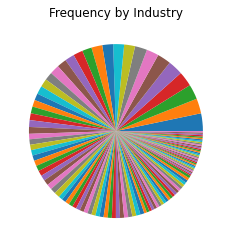

In [6]:
industry_freq = main['Industry'].value_counts(normalize = True)*100
plt.pie(industry_freq)
plt.title('Frequency by Industry')
plt.show()

The same cannot be said for industry. The most common industry is still less common than the most common sector, but the industries themselves are far more granular, with the most common more than 13 times as frequent as the least common. Note that labels were ommitted for legibility as the relative diffusion over 117 categories is enough to exclude it from further consideration.

### 4. Plan for Model Approach

To conduct a multiple regression model, I will regress the remaining quantitative features of Environmental Score, Environmental Exposure, Social Score, Social Exposure, Governance Score, and Governance Exposure, along with dummy variables for each `n-1` sectors, on the five-year return. This base case will be considered the full model and further improvements will necessarily take place via pruning.

While I don't have access to the underlying methodology used to construct scores and exposures, my hunch is that the two derive from the same data contexts given the limited sources of ESG reporting available to even the largest information collection agencies. This means that the full model, as well as any interaction that further aggregates it, may be measuring the same variation. If I struggle to produce meaningful regression results, my first attempt will be to further reduce classes of features to just one of score or exposure. 

A secondary option would be to choose a different time period- maybe my assumed five-year period smooths away the context of ESG and a shorter one would have more influential results. Downsides of this latter approach could include claims of data dredging/significance chasing, in that substantially alterning the method of analysis alters the question of engagement as there is bias against reporting null outcomes. 

In keeping with best practices for cross-validation, I will segregate my full dataset into training and test subsets using a 75:25 split as there is substantial risk of overfitting due to the large number of potential features (17), especially relative to the modest sample size (396). Given the potential for critical imbalance if sectors are partitioned into the test set but not the training set, special attention will be paid to the split by stratified about the categorical feature.

### 5/6. Models and Results/Analysis

For clarity, Analysis is integrated directly with the Models here in line with the terms of the project rubric. I found the narrative layout to provide more context as opposed to a distinct section. 

Begin by splitting the data as described above:

In [7]:
train, test = ms.train_test_split(final_data, test_size=0.25, stratify = final_data['Sector'])
train

,Company Name,Environmental Score,Environmental Exposure,Social Score,Social Exposure,Governance Score,Governance Exposure,Sector,Industry,Total Return
Ticker,,,,,,,,,,
UPS,United Parcel Service,3.5,3.0,3.0,2.3,3.7,2.0,Industrials,Air Freight & Logistics,95.042154
BAX,Baxter Intl,3.8,2.5,3.4,2.7,3.1,2.3,Health Care,Health Care Equipment,121.603692
CVS,CVS Health Corporation,3.2,2.5,3.8,2.8,2.7,2.0,Health Care,Health Care Services,-14.783539
KMX,Carmax Inc,0.5,2.0,2.0,2.0,5.0,2.0,Consumer Discretionary,Specialty Stores,166.591218
XYL,Xylem Inc.,4.3,2.3,3.0,2.3,4.0,2.3,Industrials,Industrial Machinery,186.532186
...,...,...,...,...,...,...,...,...,...,...
FB,Facebook Class A,2.5,2.0,2.0,1.5,4.5,2.0,Communication Services,Interactive Media & Services,130.220123
PRGO,Perrigo Company plc,2.0,2.5,2.0,2.0,4.5,2.0,Health Care,Pharmaceuticals,-68.685832
QRVO,Qorvo Inc.,1.4,2.8,2.5,2.5,2.8,2.5,Information Technology,Semiconductors,331.515152


This leaves 297 of 396 data points (exactly 75%) to train on as we'd hoped. Continue by implementing the initial full model on the training set:

In [8]:
#'Q' is patsy quote method for labels with spaces; balancing description and function
model_full_train = smf.ols(formula='Q("Total Return")~Q("Environmental Score")+Q("Environmental Exposure")+\
                     Q("Social Score")+Q("Social Exposure") + Q("Governance Score")+\
                     Q("Governance Exposure")+ Q("Sector") ', data=train).fit()
model_full_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q("Total Return")   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.962
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           3.04e-11
Time:                        11:05:19   Log-Likelihood:                -1865.4
No. Observations:                 297   AIC:                             3765.
Df Residuals:                     280   BIC:                             3828.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               236.1222    125.051      1.888      0.060     -10.038     482.282
Q("Sector")[T.Consumer Discretionary]   -20.1665     43.815     -0.460      0.646    -106.414      66.081
Q("Sector")[T.Consumer Staples]         -53.6002     48.987     -1.094      0.275    -150.031      42.830
Q("Sector")[T.Energy]                   -98.5523     54.501     -1.808      0.072    -205.836       8.731
Q("Sector")[T.Financials]               -26.3578     48.411     -0.544      0.587    -121.653      68.937
Q("Sector")[T.Health Care]                6.8922     43.086      0.160      0.873     -77.921      91.705
Q("Sector")[T.Industrials]               55.7970     44.463      1.255      0.211     -31.726     143.320
Q("Sector")[T.Information Technology]   183.2178     42.391      4.322      0.000      99.773     266.663
Q("Sector")[T.Materials]                 37.6047     54.033      0.696      0.487     -68.757     143.966
Q("Sector")[T.Real Estate]              -22.2230     51.765     -0.429      0.668    -124.121      79.675
Q("Sector")[T.Utilities]                 -0.0355     54.721     -0.001      0.999    -107.752     107.681
Q("Environmental Score")                 10.2623      8.292      1.238      0.217      -6.060      26.584
Q("Environmental Exposure")             -30.1617     23.968     -1.258      0.209     -77.341      17.018
Q("Social Score")                        -9.3875     12.458     -0.754      0.452     -33.910      15.135
Q("Social Exposure")                     49.2247     24.389      2.018      0.045       1.216      97.233
Q("Governance Score")                   -18.9022     11.673     -1.619      0.106     -41.880       4.075
Q("Governance Exposure")                -55.0864     53.989     -1.020      0.308    -161.363      51.190
==============================================================================
Omnibus:                      330.782   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24991.130
Skew:                           4.558   Prob(JB):                         0.00
Kurtosis:                      47.004   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The 16-feature model is huge! The Communications Services Sector is the default dropped dummy variable here (chosen alphabetically) such that it is represented by the inclusion of all quantitative features exclusively.

Of note, the adjusted R-squared of 0.211 is not great, while the Durbin-Watson statistic of 2.099 > 1.847 = dU (n=200, k=16) is interpreted to be that there is not autocorrelation of the residuals (that is, they are normally distributed).

While the model is significant as specified with a p-value of the F-statistic of zero, 12 of the features are not (when considering p-values > 0.05 of their T-statistics individually). This dichotomy of a significant model but insignificant features is often indicative of multicollinearity and thus a violation of regression assumptions.

In an attempt to fix this, I noted that the dummy variables make of the majority of these insignificant features, and ended up dropping all the sector dummy variables as they were of secondary interest. To avoid eliminating too much of the model at once  and recongizing a different functional paradigm, all scores/exposures were kept for the next interation.

In [9]:
model_esg_only_train = smf.ols(formula='Q("Total Return")~Q("Environmental Score")+Q("Environmental Exposure")+\
                     Q("Social Score")+Q("Social Exposure") + Q("Governance Score")+\
                     Q("Governance Exposure") ', data=final_data).fit()
model_esg_only_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q("Total Return")   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.421
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00265
Time:                        11:05:19   Log-Likelihood:                -2502.3
No. Observations:                 396   AIC:                             5019.
Df Residuals:                     389   BIC:                             5046.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     456.1871     97.842      4.662      0.000     263.822     648.552
Q("Environmental Score")       13.3283      6.941      1.920      0.056      -0.318      26.975
Q("Environmental Exposure")    -5.1360     14.817     -0.347      0.729     -34.267      23.995
Q("Social Score")               0.7610      9.904      0.077      0.939     -18.712      20.234
Q("Social Exposure")            6.7044     20.189      0.332      0.740     -32.990      46.398
Q("Governance Score")         -27.6295     10.129     -2.728      0.007     -47.544      -7.714
Q("Governance Exposure")     -133.1408     39.980     -3.330      0.001    -211.744     -54.537
==============================================================================
Omnibus:                      429.432   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32088.499
Skew:                           4.629   Prob(JB):                         0.00
Kurtosis:                      46.117   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With only ESG scores/exposures, R-squared dropped dramatically to 0.035. There is again no autocorrelation of the residuals (2.019 > 1.735 = dU, n=200, k=6), and the F-test is significant at the 5% level, but only `Governance Score` and `Governance Exposure` remain as significant features. As expected given the fall-off described, the intercept was more significant in this run as more variation in price return goes unexplained by the model.

I decided to run a final iteration on only the two Governance metrics that showed promise: 

In [10]:
model_gov_only_train = smf.ols(formula='Q("Total Return")~Q("Governance Score")+\
                               Q("Governance Exposure") ', data=final_data).fit()
model_gov_only_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q("Total Return")   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.744
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00132
Time:                        11:05:19   Log-Likelihood:                -2505.8
No. Observations:                 396   AIC:                             5018.
Df Residuals:                     393   BIC:                             5029.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  435.2551     92.910      4.685      0.000     252.593     617.918
Q("Governance Score")      -22.5854      9.940     -2.272      0.024     -42.127      -3.044
Q("Governance Exposure")  -111.5999     38.310     -2.913      0.004    -186.918     -36.282
==============================================================================
Omnibus:                      436.169   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34498.193
Skew:                           4.733   Prob(JB):                         0.00
Kurtosis:                      47.735   Cond. No.                         64.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a minimal decline in adjusted R-squared to 0.028 but an improvement in the F-statistic (now significant at the 0.13% level) and all regression features significant, this is a more favorable model specification for purpose. Durbin-Watson continutes to indicate no autocorrelation of the residuals (2.024 > 1.693 = dU, n=200, k=2). 

Letting this be the final model (there isn't that much else left to work with), I also calculated the Variance Inflation Factor (VIF) for the two features:

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('Q("Total Return")~Q("Governance Score")+\
                               Q("Governance Exposure") ', data=final_data, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,184.850329,Intercept
1,1.000151,"Q(""Governance Score"")"
2,1.000151,"Q(""Governance Exposure"")"


As a VIF of 1.0 indicates a lack of multicollinearity between variables in the model, `Governance Score` and `Governance Exposure`, are not correlated, confirming another tenet of an appropriately-specific regression model. The value of the intercept should be ignored as it has no equivalent interpretation.

As a final check, I ran the `Gov Only` model on the test data withheld earlier:

In [12]:
model_gov_only_test = smf.ols(formula='Q("Total Return")~Q("Governance Score")+\
                               Q("Governance Exposure") ', data=test).fit()
model_gov_only_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q("Total Return")   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.244
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.293
Time:                        11:05:19   Log-Likelihood:                -586.33
No. Observations:                  99   AIC:                             1179.
Df Residuals:                      96   BIC:                             1186.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  287.4086    129.544      2.219      0.029      30.266     544.552
Q("Governance Score")      -16.5501     15.488     -1.069      0.288     -47.294      14.194
Q("Governance Exposure")   -61.7992     51.056     -1.210      0.229    -163.145      39.547
==============================================================================
Omnibus:                       48.157   Durbin-Watson:                   2.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.678
Skew:                           1.695   Prob(JB):                     1.91e-33
Kurtosis:                       8.003   Cond. No.                         65.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results are similar to those of the training data; fit is slightly improved (adjusted r-squares of 0.005 vs 0.007), and there is no autocorrelation of the residuals (DW 2.441 > 1.502 = dL, n=99, k = 2). Note also that zero is in the confidence interval for `Governance Score` and `Governance Exposure`, hindering directionality of interpretation. As a sanity check, it seems that at the least we have avoided overfitting the model.

### 7. Discussion and Conclusion

Of all ESG factors, only Governance (through both Score and Exposure) was able to significantly explain part of a S&P 500 stock's 5-year total return from 1/29/16-1/29/21. Despite the statistical value, this had little practical meaning. Final adjusted r-squared was only 0.007, and the negative coefficient on `Governance Score` implies there was a performance penalty to companies graded higher!

Given the first model where it was intended as a control, it seems as if `Sector` played a much larger role in the determination of total return. With the exogenous prerogative to examine ESG however, this defining feature was dropped in favor of specifying the thematic ones, recognizing that there are other considerations beyond maximizing fit in developing an accurate model.

One of the greatest limitations was not knowing how the ESG metrics by FTSE Russell were calculated. From EDA, there was little internal consistency within a class, and even less between them, such that the three are likely developed via different methologies that limit their comparability despite outwardly similar scales. It may be that the measured ESG scores were intended to capture some other, tertiary  factor almost wholly unrelated to return, or that, empirically, the market does not actually reward ESG as so many claim.

Further, as an exercise in cross-sectional regression, five years of time series data was distilled into a single holding period. If this is structurally different from the period over which MSCI's ESG metrics are targeted, there would be a fundamental mismatch regardless.

It's impossible to prove a negative in this case, but I found myself without the evidence to reject the null of "no ESG impact" the vast majority of the time. Future work should consider a wider menu of features in considering drivers of return, and possibly rely on the development of custom data to align methodology with intended purpose. It may also be worthwhile to consider a data mining exercise first to explore what is significant structurally within a similar dataset, as relying on the boundaries of an existing fundamental relationship pruned away most of the potentially explained variation to nothing.

This project was a good exercise in the nuances of regression specification as it's all too often reduced to a game of maximizing adjusted r-squared by whatever means necessary, but drastic underfitting led to much less of an impact of ESG factors on stock price return than I had hoped.